In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift, fftn, ifftn

import pickle
import waveorder as wo
import time


%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Experiment parameters

In [2]:
N           = 200                 # number of pixel in y dimension
M           = 200                 # number of pixel in x dimension
L           = 100                 # number of layers in z dimension
n_media     = 1.33                # refractive index in the media
mag         = 63                  # magnification
ps          = 6.5/mag             # effective pixel size
psz         = 0.125/2             # axial pixel size
lambda_illu = 0.532               # wavelength
NA_obj      = 1.2                 # objective NA
NA_illu     = 0.9                 # illumination NA
chi         = 0.03*2*np.pi         # swing of the microscope
z_defocus = (np.r_[:L]-L//2)*psz  # defocus position
use_gpu     = True
gpu_id      = 2

### Sample creation

In [3]:
# radius = 1.5
blur_size = 1*ps
# target, azimuth, inc_angle = wo.gen_sphere_target((N,M,L), ps, psz, radius, blur_size)
# target, azimuth, inc_angle = wo.genStarTarget_3D((N,M,L), ps, psz, blur_size, inc_upper_bound=np.pi/4, inc_range=np.pi/64)
target, azimuth, inc_angle = wo.genStarTarget_3D((N,M,L), ps, psz, blur_size)

# inc_angle = (inc_angle-np.pi/2)*3+np.pi/2
# target[:,:,:45] = 0
# target[:,:,-45:] = 0

# target, azimuth, xx = wo.genStarTarget(N,M)
# xx = xx/np.max(xx)
# inc_angle = (np.abs(np.pi/2 * xx) + np.pi/2)
# azimuth = np.abs(azimuth)

# target = np.pad(target[:,:,np.newaxis], ((0,0), (0,0), (50,49)), mode='constant')
# azimuth = np.pad(azimuth[:,:,np.newaxis], ((0,0), (0,0), (50,49)), mode='constant')
# inc_angle = np.pad(inc_angle[:,:,np.newaxis], ((0,0), (0,0), (50,49)), mode='constant')

# target[:,:,51:51+2] = np.transpose(np.stack([target[:,:,50],target[:,:,50]]),(1,2,0))
# azimuth[:,:,51:51+2] = np.transpose(np.stack([azimuth[:,:,50],azimuth[:,:,50]]),(1,2,0))
# inc_angle[:,:,51:51+2] = np.transpose(np.stack([inc_angle[:,:,50],inc_angle[:,:,50]]),(1,2,0))

# target[:,:,48:50] = np.transpose(np.stack([target[:,:,50],target[:,:,50]]),(1,2,0))
# azimuth[:,:,48:50] = np.transpose(np.stack([azimuth[:,:,50],azimuth[:,:,50]]),(1,2,0))
# inc_angle[:,:,48:50] = np.transpose(np.stack([inc_angle[:,:,50],inc_angle[:,:,50]]),(1,2,0))


wo.parallel_4D_viewer(np.transpose(np.stack([target, azimuth%(2*np.pi), inc_angle]),(3,0,1,2)), num_col=3, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [4]:
wo.image_stack_viewer(np.transpose(target,(0,2,1)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=199), Output()), _dom_classes=('widget-i…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [5]:
## Physical value assignment

n_o = 1.33+0.02 
n_e = 1.33+0.07

theta = inc_angle
orientation = (azimuth)%(2*np.pi)

no_map = np.zeros((N,M,L))
no_map[target > 0] = target[target > 0]*(n_o-n_media)
no_map += n_media

ne_map = np.zeros((N,M,L))
ne_map[target > 0] = target[target > 0]*(n_e-n_media)
ne_map += n_media

epsilon_mean = (ne_map**2 + no_map**2)/2
epsilon_del = (ne_map**2 - no_map**2)/2


epsilon_tensor = np.zeros((3,3,N,M,L))
epsilon_tensor[0,0] = epsilon_mean - epsilon_del*(np.cos(theta)**2 - np.sin(theta)**2 * np.cos(2*orientation))
epsilon_tensor[0,1] = epsilon_del * np.sin(theta)**2 * np.sin(2*orientation)
epsilon_tensor[0,2] = epsilon_del * np.sin(2*theta) * np.cos(orientation)

epsilon_tensor[1,0] = epsilon_del * np.sin(theta)**2 * np.sin(2*orientation)
epsilon_tensor[1,1] = epsilon_mean - epsilon_del*(np.cos(theta)**2 + np.sin(theta)**2 * np.cos(2*orientation))
epsilon_tensor[1,2] = epsilon_del * np.sin(2*theta) * np.sin(orientation)

epsilon_tensor[2,0] = epsilon_del * np.sin(2*theta) * np.cos(orientation)
epsilon_tensor[2,1] = epsilon_del * np.sin(2*theta) * np.sin(orientation)
epsilon_tensor[2,2] = epsilon_mean + epsilon_del*np.cos(2*theta)


In [6]:
wo.parallel_4D_viewer(np.transpose(epsilon_tensor.reshape((9, N, M, L)),(3,0,1,2)), num_col=3, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [7]:
# physical properties translated in the reconstructed parameters

del_f_component = np.zeros((7, N, M, L))
del_f_component[0] = np.real(((2*np.pi/lambda_illu)**2)*(n_media**2 -  epsilon_mean + epsilon_del*np.cos(theta)**2))
del_f_component[1] = np.imag(((2*np.pi/lambda_illu)**2)*(n_media**2 -  epsilon_mean + epsilon_del*np.cos(theta)**2))
del_f_component[2] = -((2*np.pi/lambda_illu)**2) * epsilon_del * np.sin(theta)**2 * np.cos(2*orientation)
del_f_component[3] = -((2*np.pi/lambda_illu)**2) * epsilon_del * np.sin(theta)**2 * np.sin(2*orientation)
del_f_component[4] = -((2*np.pi/lambda_illu)**2) * epsilon_del * np.sin(2*theta) * np.cos(orientation)
del_f_component[5] = -((2*np.pi/lambda_illu)**2) * epsilon_del * np.sin(2*theta) * np.sin(orientation)
del_f_component[6] = ((2*np.pi/lambda_illu)**2) * epsilon_del * (np.sin(theta)**2 - 2*np.cos(theta)**2)

In [8]:
wo.parallel_4D_viewer(np.transpose(del_f_component,(3,0,1,2)), num_col=4, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

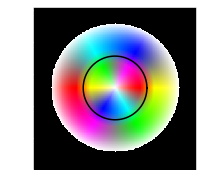

In [9]:

orientation_3D_image = np.transpose(np.array([orientation/2/np.pi, theta,  np.clip((ne_map-no_map)*psz*2*np.pi/lambda_illu/np.pi/2*lambda_illu*1e3,0, 3)/3]),(3,1,2,0))
orientation_3D_image_RGB = wo.orientation_3D_to_rgb(orientation_3D_image, interp_belt = 20/180*np.pi, sat_factor = 1)


wo.rgb_stack_viewer(orientation_3D_image_RGB, size=10, origin='lower')
plt.figure(figsize=(3,3))
wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1)

interactive(children=(IntSlider(value=0, description='stack_idx', max=199), Output()), _dom_classes=('widget-i…

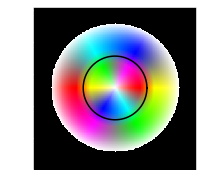

In [10]:
wo.rgb_stack_viewer(np.transpose(orientation_3D_image_RGB,(1,0,2,3)), size=10, origin='lower')
plt.figure(figsize=(3,3))
wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1)

### Setup acquisition

In [17]:
# DPC + BF illumination

xx, yy, fxx, fyy = wo.gen_coordinate((N, M), ps)
Pupil_obj = wo.gen_Pupil(fxx, fyy, NA_obj/n_media, lambda_illu/n_media)
Source_support = wo.gen_Pupil(fxx, fyy, NA_illu/n_media, lambda_illu/n_media)

NAx_coord = lambda_illu/n_media*fxx
NAy_coord = lambda_illu/n_media*fyy


rotation_angle=[0, 45, 90, 135, 180, 225, 270, 315]


Source = np.zeros((len(rotation_angle)+1, N, M))
Source_cont = np.zeros_like(Source)

Source_BF = wo.gen_Pupil(fxx, fyy, NA_illu/n_media/2, lambda_illu/n_media)
Source_cont[-1] = Source_BF.copy()
Source[-1] = wo.Source_subsample(Source_BF, NAx_coord, NAy_coord, subsampled_NA = 0.1/n_media)


for i in range(len(rotation_angle)):
    deg = rotation_angle[i]
    Source_temp = np.zeros((N,M))
    Source_temp2 = np.zeros((N,M))
    Source_temp[fyy * np.cos(np.deg2rad(deg-22.5)) - fxx*np.sin(np.deg2rad(deg-22.5)) > 1e-10] = 1
    Source_temp2[fyy * np.cos(np.deg2rad(deg-135-22.5)) - fxx*np.sin(np.deg2rad(deg-135-22.5)) > 1e-10] = 1
    Source_cont[i] = Source_temp * Source_temp2 * Source_support 
    Source_discrete = wo.Source_subsample(Source_temp * Source_temp2 * Source_support, NAx_coord, NAy_coord, subsampled_NA = 0.1/n_media)
    Source[i] = np.maximum(0,Source_discrete.copy())
    


In [27]:
# DPC + BF illumination

xx, yy, fxx, fyy = wo.gen_coordinate((N, M), ps)
Pupil_obj = wo.gen_Pupil(fxx, fyy, NA_obj/n_media, lambda_illu/n_media)
Source_support = wo.gen_Pupil(fxx, fyy, NA_illu/n_media, lambda_illu/n_media)

NAx_coord = lambda_illu/n_media*fxx
NAy_coord = lambda_illu/n_media*fyy


rotation_angle=[0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5]


Source = np.zeros((len(rotation_angle)+1, N, M))
Source_cont = np.zeros_like(Source)

Source_BF = wo.gen_Pupil(fxx, fyy, NA_illu/n_media/2, lambda_illu/n_media)
Source_cont[-1] = Source_BF.copy()
Source[-1] = wo.Source_subsample(Source_BF, NAx_coord, NAy_coord, subsampled_NA = 0.06/n_media)


for i in range(len(rotation_angle)):
    deg = rotation_angle[i]
    Source_temp = np.zeros((N,M))
    Source_temp2 = np.zeros((N,M))
    Source_temp[fyy * np.cos(np.deg2rad(deg-11.25)) - fxx*np.sin(np.deg2rad(deg-11.25)) > 1e-10] = 1
    Source_temp2[fyy * np.cos(np.deg2rad(deg-157.5-11.25)) - fxx*np.sin(np.deg2rad(deg-157.5-11.25)) > 1e-10] = 1
    Source_cont[i] = Source_temp * Source_temp2 * Source_support
    Source_discrete = wo.Source_subsample(Source_temp * Source_temp2 * Source_support, NAx_coord, NAy_coord, subsampled_NA = 0.06/n_media)
    Source[i] = np.maximum(0,Source_discrete.copy())
    


In [18]:
wo.image_stack_viewer(fftshift(Source,axes=(1,2)), origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=16), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

array([20., 19., 20., 19., 20., 19., 20., 19., 20., 21., 20., 21., 20.,
       21., 20., 21., 49.])

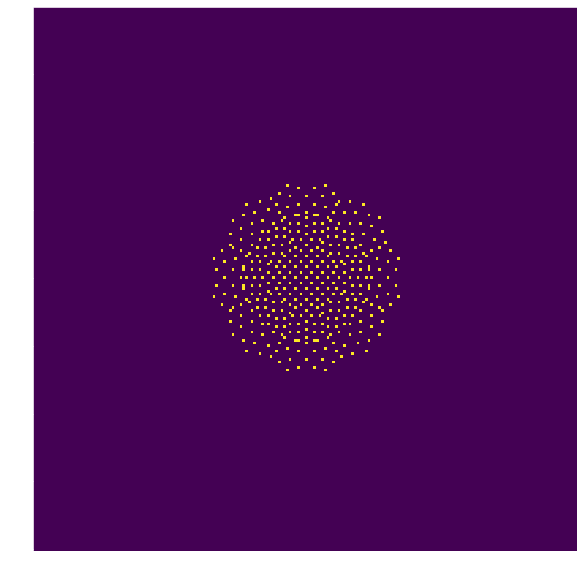

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(fftshift(np.sum(Source,axis=0)), origin='lower')
np.sum(Source,axis=(1,2))

In [20]:
setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media = n_media, inc_recon='3D', phase_deconv='3D', illu_mode = 'Arbitrary', Source=Source_cont, use_gpu=use_gpu, gpu_id=gpu_id)

simulator = wo.waveorder_microscopy_simulator((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media = n_media, illu_mode = 'Arbitrary', Source=Source, use_gpu=use_gpu, gpu_id=gpu_id)


In [15]:
import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

In [21]:
## Plotting phase and absorption transfer function (vectorial OTF not included)

z_idx = L//2

if setup.H_re.ndim == 3:
    H_re = setup.H_re[np.newaxis,:,:,:]
    H_im = setup.H_im[np.newaxis,:,:,:]

else:
    H_re = setup.H_re
    H_im = setup.H_im

wo.parallel_4D_viewer(np.transpose(np.stack([np.real(fftshift(H_re,axes=(1,2,3))[:,:,:,z_idx]), 
                                             np.imag(fftshift(H_re,axes=(1,2,3))[:,:,:,z_idx]),
                                             np.real(fftshift(H_im,axes=(1,2,3))[:,:,:,z_idx]),
                                             np.imag(fftshift(H_im,axes=(1,2,3))[:,:,:,z_idx])]),(1,0,2,3)), num_col=4, size=5, colormap='jet', origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=16), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [22]:

wo.parallel_4D_viewer(np.transpose(np.stack([np.real(fftshift(H_re,axes=(1,2,3))[:,N//2,:,:]), 
                                             np.imag(fftshift(H_re,axes=(1,2,3))[:,N//2,:,:]),
                                             np.real(fftshift(H_im,axes=(1,2,3))[:,N//2,:,:]),
                                             np.imag(fftshift(H_im,axes=(1,2,3))[:,N//2,:,:])]),(1,0,3,2)), num_col=4, size=5, colormap='jet', origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=16), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [23]:
z_idx = L//2
plot_list = []
plot_list_xz = []
for i in range(3):
    for j in range(7):
        OTF_fftshift = fftshift(setup.H_dyadic_OTF[i,j],axes=(1,2,3))
        
        plot_list.append(np.real(OTF_fftshift[:,:,:,z_idx]))
        plot_list.append(np.imag(OTF_fftshift[:,:,:,z_idx]))
        plot_list_xz.append(np.real(OTF_fftshift[:,N//2,:,:]))
        plot_list_xz.append(np.imag(OTF_fftshift[:,N//2,:,:]))

In [24]:
wo.parallel_4D_viewer(np.transpose(np.stack(plot_list), (1,0,2,3)), num_col=4, size=5, colormap='jet', origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=16), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [25]:
wo.parallel_4D_viewer(np.transpose(np.stack(plot_list_xz), (1,0,3,2)), num_col=4, size=5, colormap='jet', origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=16), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [26]:
I_meas_SEAGLE, Stokes_SEAGLE = simulator.simulate_3D_vectorial_measurements_SEAGLE(epsilon_tensor, itr_max = 0, tolerance=1e-4, verbose=False)

Number of point sources considered (1 / 20) in pattern (1 / 17), elapsed time: 1.30
Number of point sources considered (2 / 20) in pattern (1 / 17), elapsed time: 2.24
Number of point sources considered (3 / 20) in pattern (1 / 17), elapsed time: 3.06
Number of point sources considered (4 / 20) in pattern (1 / 17), elapsed time: 3.92
Number of point sources considered (5 / 20) in pattern (1 / 17), elapsed time: 4.83
Number of point sources considered (6 / 20) in pattern (1 / 17), elapsed time: 5.69
Number of point sources considered (7 / 20) in pattern (1 / 17), elapsed time: 6.51
Number of point sources considered (8 / 20) in pattern (1 / 17), elapsed time: 7.43
Number of point sources considered (9 / 20) in pattern (1 / 17), elapsed time: 8.33
Number of point sources considered (10 / 20) in pattern (1 / 17), elapsed time: 9.18
Number of point sources considered (11 / 20) in pattern (1 / 17), elapsed time: 10.06
Number of point sources considered (12 / 20) in pattern (1 / 17), elapsed

In [27]:
wo.parallel_5D_viewer(np.transpose(Stokes_SEAGLE,(4,1,0,2,3)), num_col=4, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [28]:
wo.parallel_5D_viewer(np.transpose(I_meas_SEAGLE,(4,1,0,2,3)), num_col=5, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [29]:
# Add noise to the measurement

photon_count = 5000
# ext_ratio    = 100
# const_bg     = photon_count/(0.5*(1-np.cos(chi)))/ext_ratio

# I_meas_noise = (np.random.poisson(I_meas_SEAGLE/np.mean(I_meas_SEAGLE) * photon_count + const_bg)).astype('float64')


I_meas_noise = I_meas_SEAGLE/np.mean(I_meas_SEAGLE) * photon_count

In [30]:
wo.parallel_5D_viewer(np.transpose(I_meas_noise,(4,1,0,2,3)), num_col=5, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [31]:
# Save simulations

f = open('simulation_data_3D_Pol_phase_inc_NA_illu_09_no_135_ne_140_17_illu_theta_no_noise_Born.pckl', 'wb')
pickle.dump((I_meas_noise, lambda_illu, n_media, ps, psz, NA_obj, NA_illu, Source_cont, z_defocus, chi), f)
f.close()

In [27]:
import cupy
import gc
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

In [25]:
del_f_component_f = fftn(del_f_component,axes=(1,2,3))

S_stack_f = np.zeros((3, 9, N, M, L), complex)

for i in range(3):
    for j in range(7):
        S_stack_f[i] += setup.H_dyadic_OTF[i,j]*(del_f_component_f[j])[np.newaxis,...]
        
S_stack = np.real(ifftn(S_stack_f, axes=(2,3,4)))
        

In [26]:
wo.parallel_5D_viewer(np.transpose(S_stack,(4,1,0,2,3)), num_col=4, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [27]:
reg_inc = np.array([1, 1, 1e1, 1e1, 1e1, 1e1, 1e1])*1
reg_ret_ap = 1e-2


del_f_sol, retardance_ap, azimuth, theta = setup.Inclination_recon_3D_vec(S_stack, \
                                                                          reg_inc=reg_inc, reg_ret_ap = reg_ret_ap)

Finished preprocess, elapsed time: 16.80
Finished reconstruction, elapsed time: 37.12


In [28]:
wo.parallel_4D_viewer(np.transpose(del_f_sol,(3,0,1,2)), num_col=4, origin='lower')


interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [29]:
wo.parallel_4D_viewer(np.transpose(np.stack([-del_f_sol[0]/(4*np.pi/lambda_illu*n_media)*psz, \
                                             retardance_ap/(2*np.pi/lambda_illu*n_media)*psz/2/np.pi*lambda_illu*1e3, \
                                             azimuth, theta]),(3,0,1,2)), num_col=4, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

Text(0.5, 1.0, 'recon')

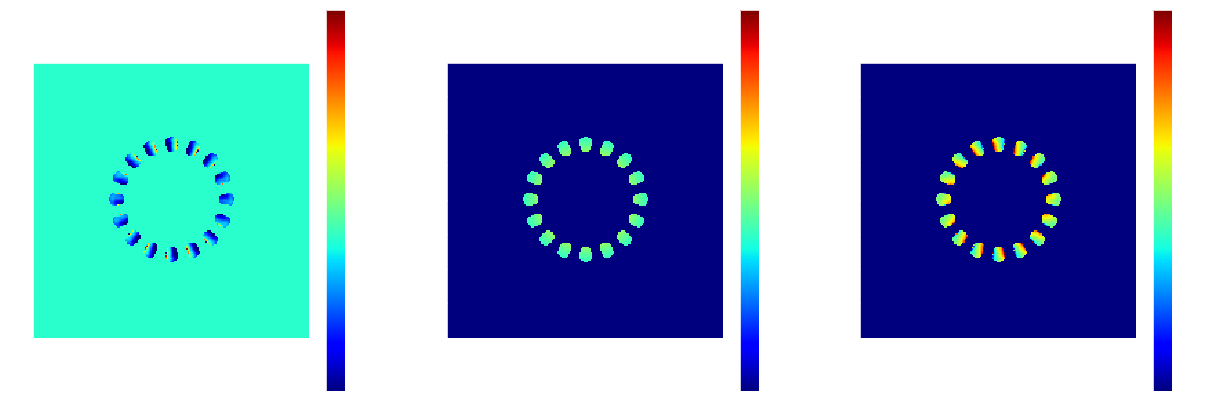

In [30]:
blur_size = 1*ps
# target, azimuth_t, inc_angle = wo.genStarTarget_3D((N,M,L), ps, psz, blur_size, inc_upper_bound=np.pi/4, inc_range=np.pi/64)
target, azimuth_t, inc_angle = wo.genStarTarget_3D((N,M,L), ps, psz, blur_size)

mask = target.copy()
mask[mask>0.2] = 1
mask[mask<=0.2] = 0
# mask = np.ones_like(target)

fig, ax = plt.subplots(1,3,figsize=(21,7))
ax1 = ax[0].imshow((mask*(inc_angle-(np.abs(theta-np.pi/2)+np.pi/2)))[:,:,25]/np.pi*180, cmap='jet', origin='lower', vmin=-10, vmax=15)
plt.colorbar(ax1,ax=ax[0])
ax2 = ax[1].imshow((mask*inc_angle)[:,:,25]/np.pi*180, cmap='jet', origin='lower', vmin=90, vmax=135)
plt.colorbar(ax2,ax=ax[1])
ax3 = ax[2].imshow((mask*(np.abs(theta-np.pi/2)+np.pi/2))[:,:,25]/np.pi*180, cmap='jet', origin='lower',vmin=90, vmax=135)
plt.colorbar(ax3,ax=ax[2])


ax[0].set_title('ground truth - recon')
ax[1].set_title('ground truth')
ax[2].set_title('recon')


In [44]:
(np.sum((mask*(inc_angle-(np.abs(theta-np.pi/2)+np.pi/2)))[:,:,25]**2)/np.sum(mask[:,:,25]))**0.5*180/np.pi

3.4567613409873457

In [108]:
(np.sum((mask*(inc_angle-(np.abs(theta-np.pi/2)+np.pi/2)))[:,:,25]**2)/np.sum(mask[:,:,25]))**0.5*180/np.pi

2.56317453182007

In [31]:
(np.sum((mask*(inc_angle-(np.abs(theta-np.pi/2)+np.pi/2)))[:,:,25]**2)/np.sum(mask[:,:,25]))**0.5*180/np.pi

7.960042167098466